In [2]:
%matplotlib inline

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.9, rc={'text.usetex': True})
sns.set_style('whitegrid')

import argparse as ap
import model
from pathlib import Path
import json
import torch
import numpy as np
import random
from tools import f
import os
from copy import deepcopy

In [105]:
p_bootstrapping = Path('log/bootstrapping/models')
p_anchoring = Path('log/anchoring_l:0.0001/models')
p_denn = Path('log/repulsive/models')
p_prior = Path('log/prior_bs_beta:0.1/models')

dataset_seed = 2020

In [106]:
# Loading dataset
torch.manual_seed(dataset_seed)
np.random.seed(dataset_seed)
random.seed(dataset_seed)

x_train = (np.random.rand(10).reshape(-1, 1) - 1) / 2  # x between -0.5 and 0.0
y_train = f(x_train)

x_gt = np.linspace(-0.5, 0.5, 200).reshape(-1, 1)
y_gt = f(x_gt)

In [107]:
# Computations
# DROPOUT
# ------------------------------------------------- 
pconf = 'log/dropout/config.json'
pmodel = 'log/dropout/models/dropout_lr:0.001_dr:0.200_5000epochs.pt'
title = 'Dropout, $p = 0.2$'

# Load configuration
with open(Path(pconf), 'r') as fd:
    config = json.load(fd)
    
# Load model
net = model.MLP(dropout_rate=config['dropout_rate'])
net.load_state_dict(torch.load(Path(pmodel)))

# Inference
out = []
x = torch.linspace(-.5, .5, 200).view(-1, 1)
for _ in range(50):
    net.eval()  # To keep the dropout
    with torch.no_grad():
        net.generate_mask()
        out.append(net(x).view(-1))

res = torch.stack(out, 0)
f_dropout = res[0, :].numpy()
m_dropout, s_dropout = res.mean(0), res.std(0)

# ---------------------
# Anchoring
# Load models
net = model.MLP(dropout_rate=0.0)
nets = []
for modelname in [e for e in os.listdir(p_anchoring) if e[-2:] == 'pt']:
    mynet = deepcopy(net)
    mynet.load_state_dict(torch.load(Path(p_anchoring) / modelname))
    nets.append(mynet)

# Inference
out = []
x = torch.linspace(-.5, .5, 200).view(-1, 1)
for net in nets:
    net.eval()  # To keep the dropout
    with torch.no_grad():
        out.append(net(x).view(-1))

res = torch.stack(out, 0)
f_anchoring = res[0, :].numpy()
m_anchoring, s_anchoring = res.mean(0), res.std(0)

# ---------------------
# Bootstrapping
# Load models
net = model.MLP(dropout_rate=0.0)
nets = []
for modelname in [e for e in os.listdir(p_bootstrapping) if e[-2:] == 'pt']:
    mynet = deepcopy(net)
    mynet.load_state_dict(torch.load(Path(p_bootstrapping) / modelname))
    nets.append(mynet)

# Inference
out = []
x = torch.linspace(-.5, .5, 200).view(-1, 1)
for net in nets:
    net.eval()  # To keep the dropout
    with torch.no_grad():
        out.append(net(x).view(-1))

res = torch.stack(out, 0)
f_bootstrapping = res[0, :].numpy()
m_bootstrapping, s_bootstrapping = res.mean(0), res.std(0)

# ---------------------
# Prior
# Load models
net = model.MLP(dropout_rate=0.0)
nets = []
for modelname in [e for e in os.listdir(p_prior) if e[-2:] == 'pt']:
    mynet = deepcopy(net)
    mynet.load_state_dict(torch.load(Path(p_prior) / modelname))
    nets.append(mynet)

# Inference
out = []
x = torch.linspace(-.5, .5, 200).view(-1, 1)
for net in nets:
    net.eval()  # To keep the dropout
    with torch.no_grad():
        out.append(net(x).view(-1))

res = torch.stack(out, 0)
f_prior = res[0, :].numpy()
m_prior, s_prior = res.mean(0), res.std(0)

# ---------------------
# DENN
# Load models
net = model.MLP(dropout_rate=0.0)
nets = []
for modelname in [e for e in os.listdir(p_denn) if e[-2:] == 'pt']:
    mynet = deepcopy(net)
    mynet.load_state_dict(torch.load(Path(p_denn) / modelname))
    nets.append(mynet)

# Inference
out = []
x = torch.linspace(-.5, .5, 200).view(-1, 1)
for net in nets:
    net.eval()  # To keep the dropout
    with torch.no_grad():
        out.append(net(x).view(-1))

res = torch.stack(out, 0)
f_denn = res[0, :].numpy()
m_denn, s_denn = res.mean(0), res.std(0)

In [108]:
# First line

In [109]:
def add_std(ax, m_, s_):
    ax.fill_between(x.numpy().reshape(-1), m_ - 3 * s_, m_ + 3 * s_, color='b', alpha=.1)
    ax.fill_between(x.numpy().reshape(-1), m_ - 2 * s_, m_ + 2 * s_, color='b', alpha=.2)
    ax.fill_between(x.numpy().reshape(-1), m_ - s_, m_ + s_, color='b', alpha=.3, label='Standard deviations')

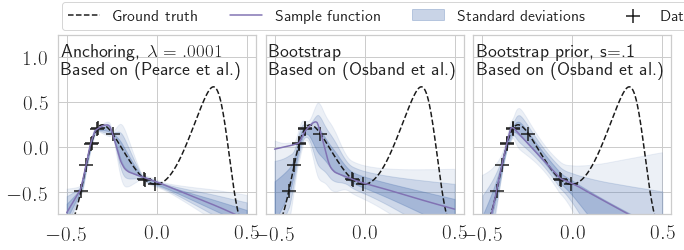

In [112]:
fig, axes = plt.subplots(1, 3, figsize=(11, 3.3), squeeze=False, sharex=True, sharey=True)


ax = axes[0, 0]
ax.plot(x_gt, y_gt, 'k--', label='Ground truth')
add_std(ax, m_anchoring, s_anchoring)
ax.plot(x.numpy(), f_anchoring, c='m', label='Sample function')
ax.scatter(x_train, y_train, marker='+', c='k', s=200, label='Data')
ax.axis([-.55, .55, -.75, 1.25])
ax.text(-0.53, 1.00, 'Anchoring, $\lambda=.0001$', fontsize=19)
ax.text(-0.53, .80, 'Based on (Pearce et al.)', fontsize=19)
fig.legend(ncol=4, prop={'size':16}, loc=(.09, .88))

ax = axes[0, 1]
ax.plot(x_gt, y_gt, 'k--', label='Ground truth')
add_std(ax, m_bootstrapping, s_bootstrapping)
ax.plot(x.numpy(), f_bootstrapping, c='m', label='Sample function')
ax.scatter(x_train, y_train, marker='+', c='k', s=200, label='Data')
ax.axis([-.55, .55, -.75, 1.25])
ax.text(-0.53, 1.0, 'Bootstrap', fontsize=19)
ax.text(-0.53, .8, 'Based on (Osband et al.)', fontsize=19)

ax = axes[0, 2]
ax.plot(x_gt, y_gt, 'k--', label='Ground truth')
add_std(ax, m_prior, s_prior)
ax.plot(x.numpy(), f_prior, c='m', label='Sample function')
ax.scatter(x_train, y_train, marker='+', c='k', s=200, label='Data')
ax.axis([-.55, .55, -.75, 1.25])
ax.text(-0.53, 1., 'Bootstrap prior, s=.1', fontsize=19)
ax.text(-0.53, .8, 'Based on (Osband et al.)', fontsize=19)
plt.subplots_adjust(hspace=.05, wspace=.05)
#plt.tight_layout()
filename = '1d-regression-top'
path_figs = Path('img')
if not Path.exists(path_figs):
    os.makedirs(path_figs)
path_savefig = path_figs / '{}.pdf'.format(filename)
fig.savefig(path_savefig)

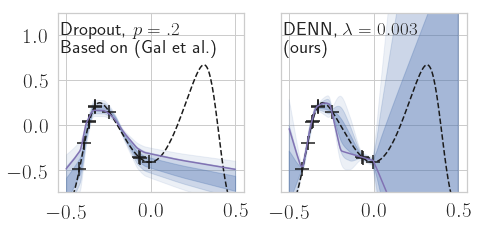

In [111]:
fig, axes = plt.subplots(1, 2, figsize=(7.33, 3.3), squeeze=False, sharex=True, sharey=True)


ax = axes[0, 0]
ax.plot(x_gt, y_gt, 'k--', label='Ground truth')
add_std(ax, m_dropout, s_dropout)
ax.plot(x.numpy(), f_dropout, c='m', label='Sample function')
ax.scatter(x_train, y_train, marker='+', c='k', s=200, label='Data')
ax.axis([-.55, .55, -.75, 1.25])
ax.text(-0.53, 1., 'Dropout, $p=.2$', fontsize=19)
ax.text(-0.53, .8, 'Based on (Gal et al.)', fontsize=19)

ax = axes[0, 1]
ax.plot(x_gt, y_gt, 'k--', label='Ground truth')
add_std(ax, m_denn, s_denn)
ax.plot(x.numpy(), f_denn, c='m', label='Sample function')
ax.scatter(x_train, y_train, marker='+', c='k', s=200, label='Data')
ax.axis([-.55, .55, -.75, 1.25])
ax.text(-0.53, 1., 'DENN, $\lambda=0.003$', fontsize=19)
ax.text(-0.53, .8, '(ours)', fontsize=19)
filename = '1d-regression-bottom'
path_figs = Path('img')
if not Path.exists(path_figs):
    os.makedirs(path_figs)
path_savefig = path_figs / '{}.pdf'.format(filename)
fig.savefig(path_savefig)

save=True

In [ ]:
if save:
    filename = '1d-regression-neurips'
    path_figs = Path('img')
    if not Path.exists(path_figs):
        os.makedirs(path_figs)
    path_savefig = path_figs / '{}.pdf'.format(filename)
    fig.savefig(path_savefig)